# Importance weighted autoenocder in Tensorflow

This code is strongly inspired by this page.(https://jmetzen.github.io/2015-11-27/vae.html)

In that page,there is  a good "VAE" code  written by Jan Hendrik Metzen.

I've changed some points.
The main differences are as follows.

* Use batch normalization
* Make it possible to sample many times.
* Use importance weighted sampling.(See the papaer written by Y.Burda https://arxiv.org/abs/1509.00519 in detail)


In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/g3doc/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [4]:
class ImportanceVariationalAutoencoder(object):
    """ Importance weighted autoencoder (IWAE) by TensorFlow
    Tha main frame is similar to VAE. 
    However,in IWAE, we sample from log(p/q) directly. In addition, Use importance weighted sampling.
    See the paper  https://arxiv.org/abs/1509.00519 in detail.
    """
    def __init__(self, network_architecture,sampling_number,transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        self.z_list = []
        self.x_reconstr_mean_list = []
        self.layer_1_list = []
        self.layer_2_list = []
        self.eps_list = []
        self.sampling_number = sampling_number
        
        self.random_call()
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    
    def random_call(self):
        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        return eps
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)


        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])
        
        for i in range(self.sampling_number):
            self.eps_list.append(self.random_call())
            self.z_list.append(tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), self.eps_list[i])))


        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        for i in range(self.sampling_number):
            self.x_reconstr_mean_list.append(self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"],i))
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):

        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases,iii):
 
        self.layer_1_list.append(self.transfer_fct(tf.add(tf.matmul(self.z_list[iii], weights['h1']), 
                                           biases['b1'])))
        self.layer_2_list.append(self.transfer_fct(tf.add(tf.matmul(self.layer_1_list[iii], weights['h2']), 
                                           biases['b2'])))
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(self.layer_2_list[iii], weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
            
    def _create_loss_optimizer(self):

        for iii in range(self.sampling_number):
            if iii==0:
                reconst_loss = tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean_list[iii])
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean_list[iii]),
                        1)
                latent1 = - tf.reduce_sum(tf.square(self.z_mean)+tf.square(self.z_log_sigma_sq),1)
        
                latent2 = tf.reduce_sum(tf.square(self.eps_list[iii]),1)
                 
                total_loss = reconst_loss+latent1+latent2
            else:
                reconst_loss = tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean_list[iii])
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean_list[iii]),
                        1)
                latent1 = - tf.reduce_sum(tf.square(self.z_mean)+tf.square(self.z_log_sigma_sq),1)
        
                latent2 = tf.reduce_sum(tf.square(self.eps_list[iii]),1)
                 
                hoge = reconst_loss+latent1+latent2

                total_loss = tf.concat(0,[total_loss,hoge])
        
        total_loss = tf.reshape(total_loss,[self.sampling_number,self.batch_size]) ####  normal total_loss
        #### calculate importance weight
        total_loss2 = tf.transpose(total_loss)
        total_loss2 = tf.nn.softmax(total_loss2)
        total_loss2 = tf.transpose(total_loss2)
        importance_weight = tf.identity(total_loss2)/tf.reduce_sum(tf.identity(total_loss2),0)  
        self.importance_weight = importance_weight
        ### caluclate importance weighted loss
        total_loss3 = importance_weight*total_loss
        total_batch_loss = tf.reduce_sum(total_loss3,0)
                               
        self.cost = -tf.reduce_mean(total_batch_loss)  # average over batch
        
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""

        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])

        return self.sess.run(self.x_reconstr_mean_list[0]+self.x_reconstr_mean_list[1]*0.5, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use IWAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean_list, 
                             feed_dict={self.x: X})

In [5]:
## make train function
""" IN this code, we can change sampling times."""

def train(network_architecture,sampling_number,learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    iwae = ImportanceVariationalAutoencoder(network_architecture, sampling_number,
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = iwae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost)
    return iwae

## Illustrating reconstruction quality

We can now train a IWAE on MNIST by just specifying the network topology. 

In [6]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=50)  # dimensionality of latent space

iwae = train(network_architecture, training_epochs=50,sampling_number=5) ### set sampling number 15

Epoch: 0001 cost= 134.998534088
Epoch: 0002 cost= 105.386688288
Epoch: 0003 cost= 93.060654463
Epoch: 0004 cost= 87.415356972
Epoch: 0005 cost= 83.766120314
Epoch: 0006 cost= 81.063592224
Epoch: 0007 cost= 79.390187891
Epoch: 0008 cost= 78.220478197
Epoch: 0009 cost= 77.207804940
Epoch: 0010 cost= 76.345431477
Epoch: 0011 cost= 75.958277061
Epoch: 0012 cost= 75.411464788
Epoch: 0013 cost= 74.850239563
Epoch: 0014 cost= 74.396559767
Epoch: 0015 cost= 74.026623396
Epoch: 0016 cost= 73.738605867
Epoch: 0017 cost= 73.340797965
Epoch: 0018 cost= 73.042739244
Epoch: 0019 cost= 72.784756317
Epoch: 0020 cost= 72.557547344
Epoch: 0021 cost= 72.291699330
Epoch: 0022 cost= 72.116500001
Epoch: 0023 cost= 71.872119238
Epoch: 0024 cost= 71.666433105
Epoch: 0025 cost= 71.524322489
Epoch: 0026 cost= 71.400096685
Epoch: 0027 cost= 71.174252798
Epoch: 0028 cost= 71.058166129
Epoch: 0029 cost= 70.888666840
Epoch: 0030 cost= 70.753849654
Epoch: 0031 cost= 70.638032081
Epoch: 0032 cost= 70.626799635
Epoch:

Show test input and reconstruction data as follows.

You can easily find that the reconstruted data by IWAE is more clear than the image generated by VAE.

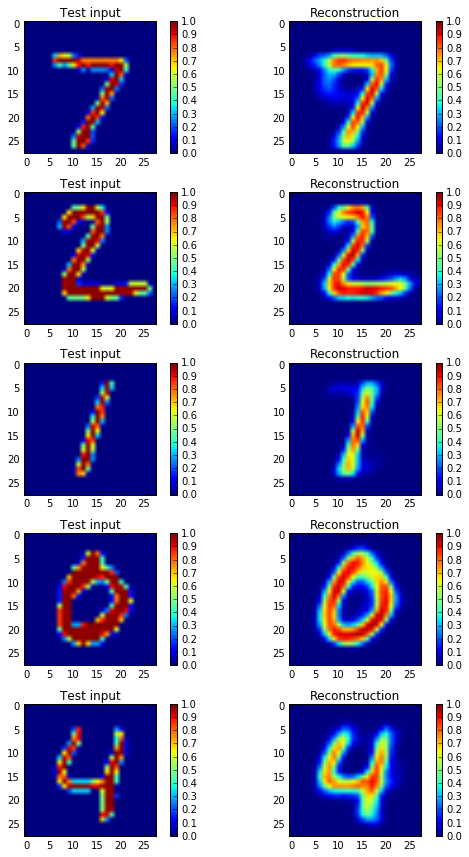

In [7]:
x_sample = mnist.test.images[0:100]
x_reconstruct = np.mean(iwae.reconstruct(x_sample),0)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
plt.savefig("my3.png")